<b style='font-size:2em'>Tutorial 2 – Solving pre-defined partial differential equations</b>

This second part of the tutorial dives into actual partial differential equations.

In [1]:
# import the package
import numpy as np
import pde

## Simple interface for solving PDEs

In the simplest case, a PDE evolves a field in time. To reflect this in code, we first define an initial state and then use a simple PDE to evolve it in time.

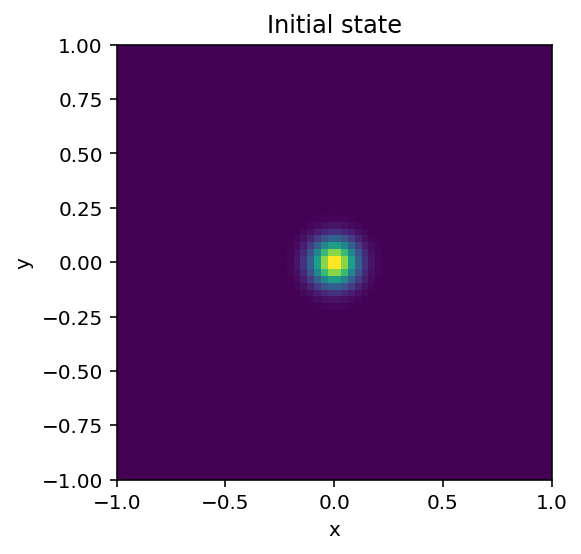

In [2]:
grid = pde.CartesianGrid([[-1, 1], [-1, 1]], 64)
state = pde.ScalarField.from_expression(grid, 'exp(-(x**2 + y**2) * 100)')
state.plot(title='Initial state');

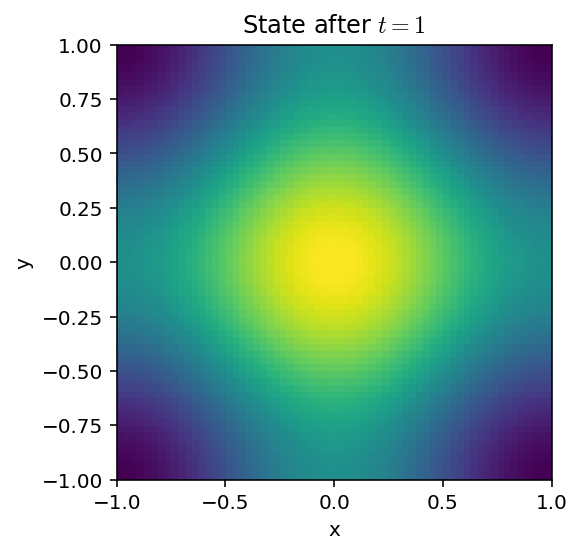

In [3]:
eq = pde.DiffusionPDE()
result = eq.solve(state, t_range=1, dt=1e-4)
result.plot(title='State after $t=1$');

Other PDEs can be solved similarly, but might require different initial conditions and/or solution parameters (e.g., `dt`).

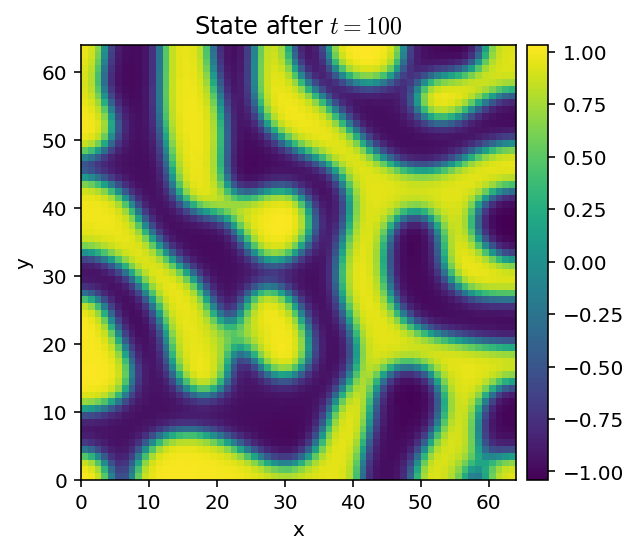

In [4]:
grid = pde.UnitGrid([64, 64])
state = pde.ScalarField.random_uniform(grid, -1, 1)

eq = pde.CahnHilliardPDE()
result = eq.solve(state, t_range=1e2, dt=1e-3)
result.plot(title='State after $t=100$', colorbar=True);

The boundary conditions applied to the differential operators of the PDE are usually specified as attributes of the PDE class.

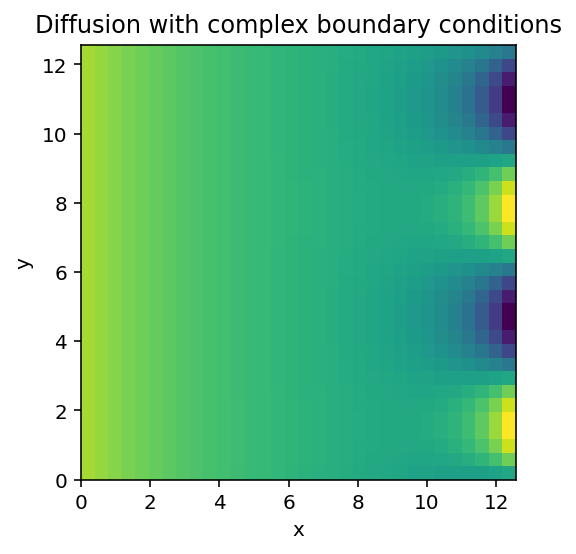

In [5]:
grid = pde.CartesianGrid([[0, 4*np.pi], [0, 4*np.pi]], [32, 32], periodic=[False, True])
state = pde.ScalarField.random_uniform(grid, 0.2, 0.3)

# set boundary conditions `bc` for all axes
bc_x_left = {'derivative': 0.1}
bc_x_right = {'value': 'sin(y)'}
bc_x = [bc_x_left, bc_x_right]
bc_y = 'periodic'
eq = pde.DiffusionPDE(bc=[bc_x, bc_y])

result = eq.solve(state, t_range=10, dt=0.005)
result.plot(title='Diffusion with complex boundary conditions');

PDEs can also be solved on grids enforcing symmetries.

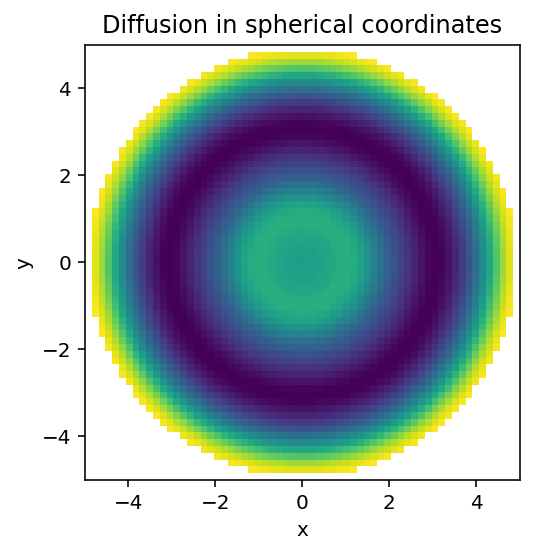

In [6]:
grid = pde.SphericalGrid([0, 5], 32)
state = pde.ScalarField.random_uniform(grid)

eq = pde.DiffusionPDE()
result = eq.solve(state, t_range=0.1, dt=0.005)
result.plot_image(title='Diffusion in spherical coordinates');

## Trackers

Trackers provide a way to access, analyze, and store information during the evolution of a PDE.

In [7]:
grid = pde.UnitGrid([128, 128])
state = pde.ScalarField.random_uniform(grid, -0.5, 0.5)
eq = pde.CahnHilliardPDE()

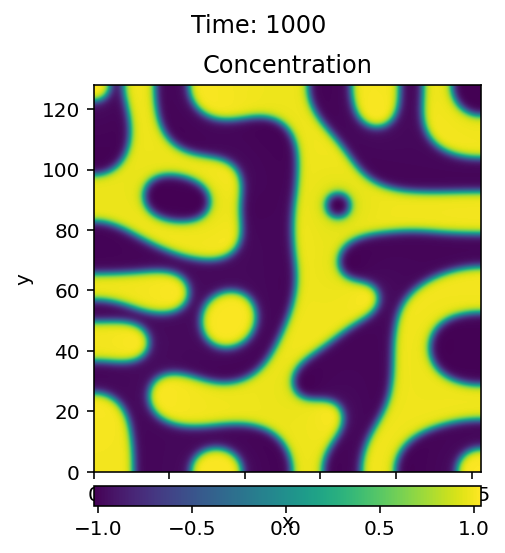

In [8]:
# Show the evolution while computing it
eq.solve(state, t_range=1e3, dt=0.01, tracker=pde.PlotTracker(interval=100));

In [9]:
# reduced output
trackers = [
    'progress',
    pde.PrintTracker(interval='0:01')  # print output roughly every real second
]

eq.solve(state, t_range=1e3, dt=0.01, tracker=trackers);

t=0, c=0.000978±0.288
t=0.03, c=0.000978±0.2
t=0.07, c=0.000978±0.162
t=0.14, c=0.000978±0.136
t=1.33, c=0.000978±0.11
t=12.85, c=0.000978±0.464
t=49.34, c=0.000978±0.703
t=116.15, c=0.000978±0.774
t=210.28, c=0.000978±0.811
t=320.97, c=0.000978±0.835
t=437.97, c=0.000978±0.852
t=559.07, c=0.000978±0.861
t=685.11, c=0.000978±0.871
t=812.48, c=0.000978±0.878
t=939.34, c=0.000978±0.884



Data can also be stored in memory and in files

In [10]:
storage = pde.MemoryStorage()
eq.solve(state, 100, dt=0.01, tracker=storage.tracker(interval=10))

for field in storage:
    print(f"{field.integral:.3g}, {field.fluctuations:.3g}")

16, 0.288
16, 0.369
16, 0.59
16, 0.65
16, 0.682
16, 0.704
16, 0.722
16, 0.735
16, 0.747
16, 0.755
16, 0.762


In [11]:
storage_write = pde.FileStorage('simulation.hdf')
eq.solve(state, 100, dt=0.01, tracker=storage_write.tracker(interval=10));

In [12]:
storage_read = pde.FileStorage('simulation.hdf')
for field in storage_read:
    print(f"{field.integral:.3g}, {field.fluctuations:.3g}")

16, 0.288
16, 0.369
16, 0.59
16, 0.65
16, 0.682
16, 0.704
16, 0.722
16, 0.735
16, 0.747
16, 0.755
16, 0.762


## Stochastic simulations

Some PDE classes support stochastic simulations. Here, a noise term is added to the evolution rate of the PDE. This noise term is interpreted in the Itô interpretation and the standard PDE classes only support additive noise.

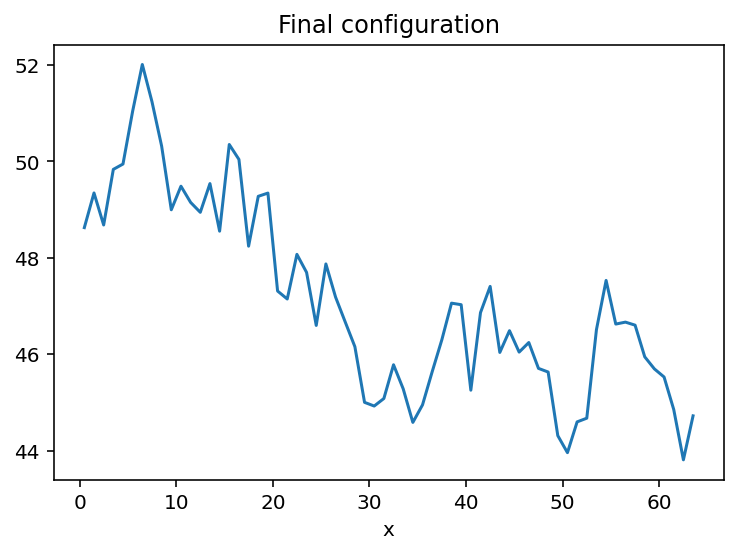

In [13]:
grid = pde.UnitGrid([64])
state = pde.ScalarField.random_harmonic(grid)

eq = pde.KPZInterfacePDE(noise=1)
storage = pde.MemoryStorage()
result = eq.solve(state, t_range=100, dt=0.01, tracker=storage.tracker(1))
result.plot(title='Final configuration');

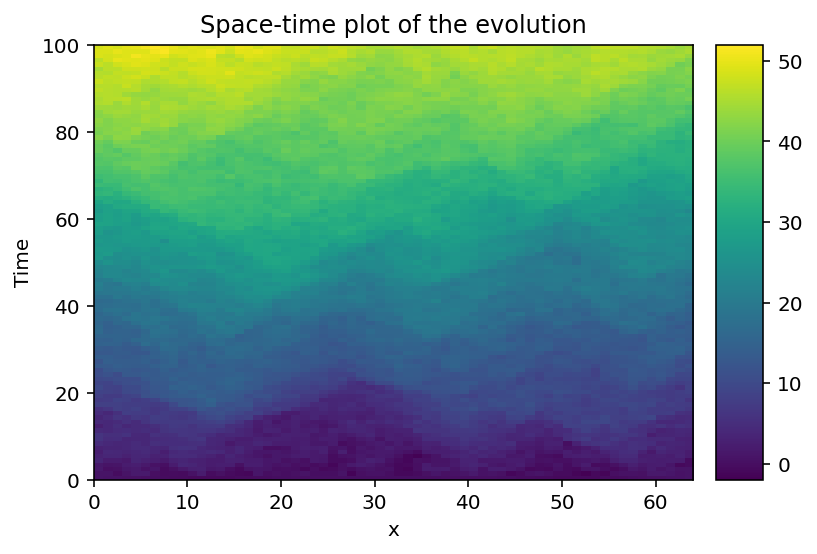

In [14]:
pde.plot_kymograph(storage, title='Space-time plot of the evolution');

## Poisson's and Laplace's equation
Beside solving for the time evolution of typical partial differential equations, we can also solve Poisson's and Laplace's problem, $\nabla^2 u = -f$, where $f=0$ in the Laplace case.

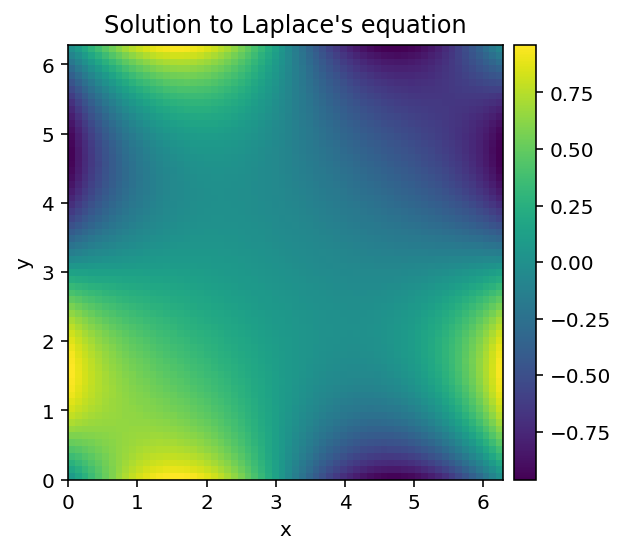

In [15]:
grid = pde.CartesianGrid([[0, 2 * np.pi]] * 2, 64)
bcs = [{'value': 'sin(y)'}, {'value': 'sin(x)'}]

field_zero = pde.ScalarField(grid)
result_laplace = field_zero.solve_poisson(bcs)
result_laplace.plot(title="Solution to Laplace's equation", colorbar=True);

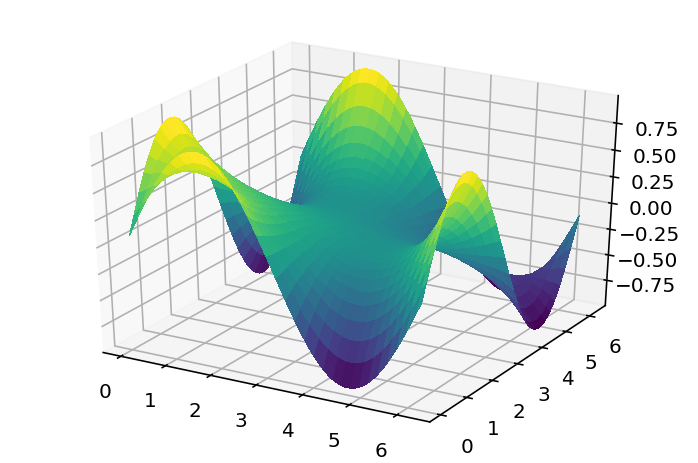

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
ax = plt.figure().gca(projection='3d')
x = grid.cell_coords[..., 0]
y = grid.cell_coords[..., 1]
z = result_laplace.data
surf = ax.plot_surface(x, y, z, cmap='viridis',
                       linewidth=0, antialiased=False)

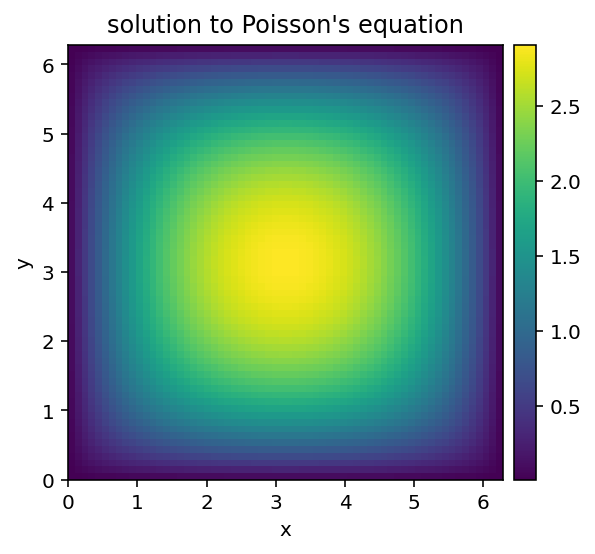

In [17]:
field_one = pde.ScalarField(grid, -1)
result_poisson = field_one.solve_poisson(bc={'value': '0'})
result_poisson.plot(colorbar=True);

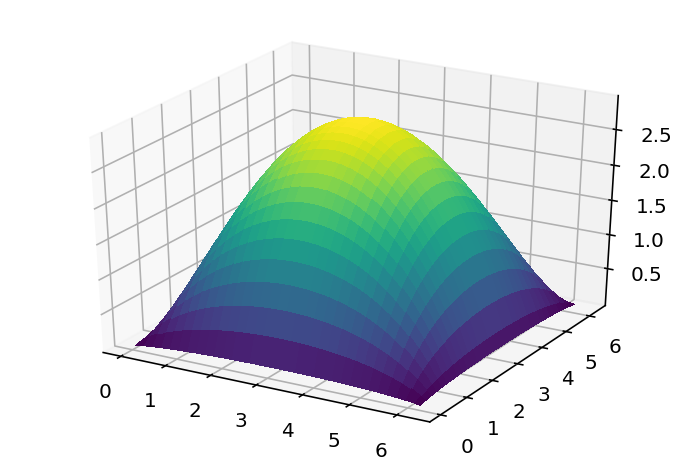

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
ax = plt.figure().gca(projection='3d')
x = grid.cell_coords[..., 0]
y = grid.cell_coords[..., 1]
z = result_poisson.data
surf = ax.plot_surface(x, y, z, cmap='viridis',
                       linewidth=0, antialiased=False)

In [19]:
result_poisson.laplace(bc={'value': '0'})

ScalarField(grid=CartesianGrid(bounds=((0.0, 6.283185307179586), (0.0, 6.283185307179586)), shape=(64, 64), periodic=[False, False]), data=[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]], label="laplace")

## User defined PDEs
Custom PDEs can be defined using all the machinery exposed by the package.

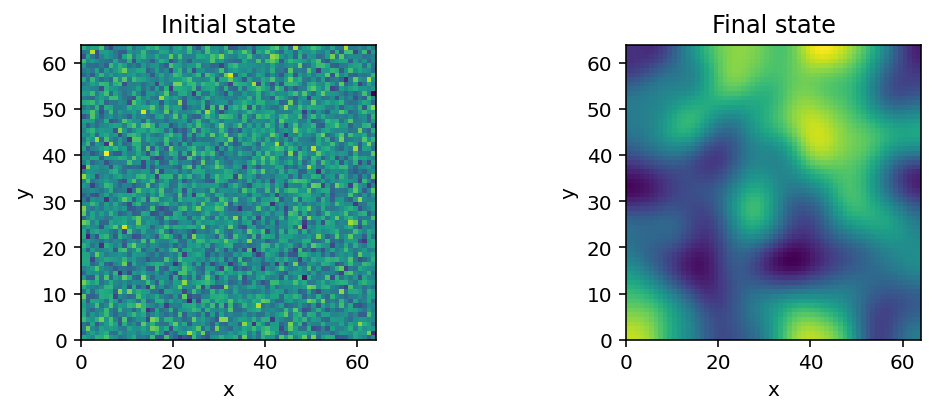

In [20]:
# define a simple diffusion equation
eq = pde.PDE({'u': "laplace(u)"})

# initialize state
grid = pde.UnitGrid([64, 64])
state = pde.ScalarField.random_normal(grid, label='Initial state')

# simulate the pde
sol = eq.solve(state, t_range=10, dt=1e-2)
sol.label = 'Final state'

# compare the initial and final state
pde.FieldCollection([state, sol]).plot();

The `PDE` class also supports multiple fields and vectorial PDEs.

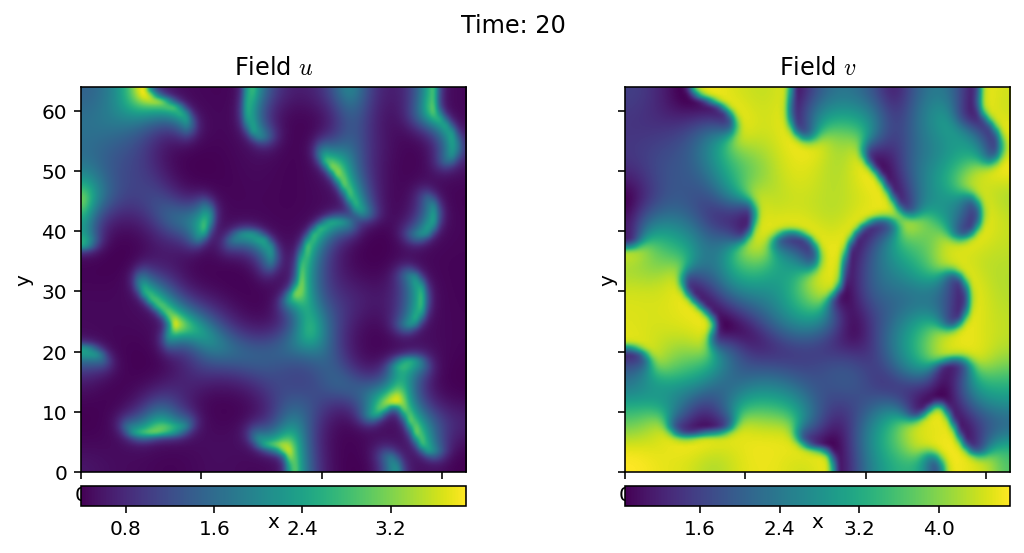

Spent more time on handling trackers (8.077732000000012) than on the actual simulation (3.247980999999996)


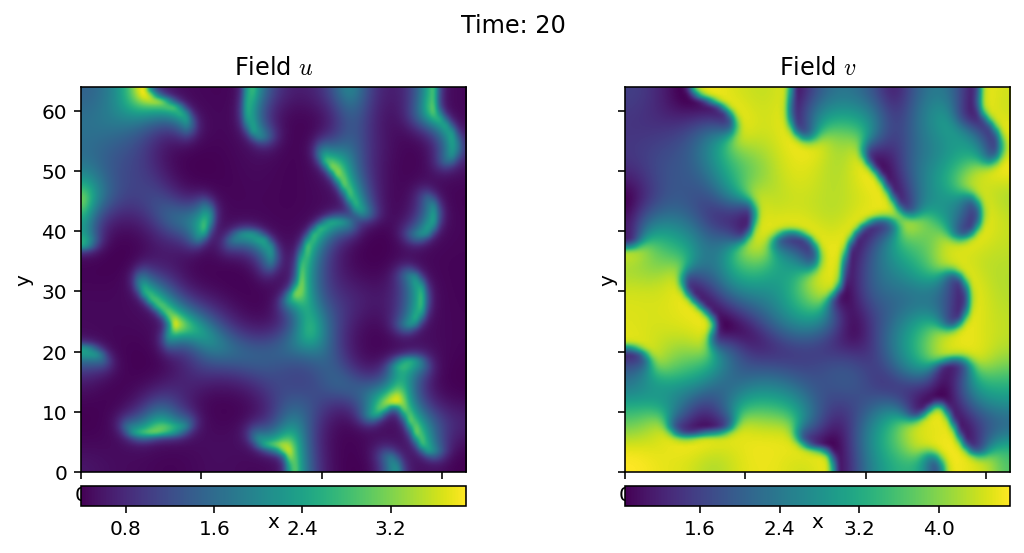

In [21]:
# define the Brusselator PDE
a, b = 1, 3
d0, d1 = 1, 0.1
eq = pde.PDE({'u': f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
              'v': f"{d1} * laplace(v) + {b} * u - u**2 * v"})

# initialize state
grid = pde.UnitGrid([64, 64])
u = pde.ScalarField(grid, a, label='Field $u$')
v = b / a + 0.1 * pde.ScalarField.random_normal(grid, label='Field $v$')
state = pde.FieldCollection([u, v])

# simulate the pde
sol = eq.solve(state, t_range=20, dt=1e-3, tracker=pde.PlotTracker())

The `PDE` class allows a straight-forward implementation of simple PDEs. If more control is necessary, `PDEBase` can be subclasses.

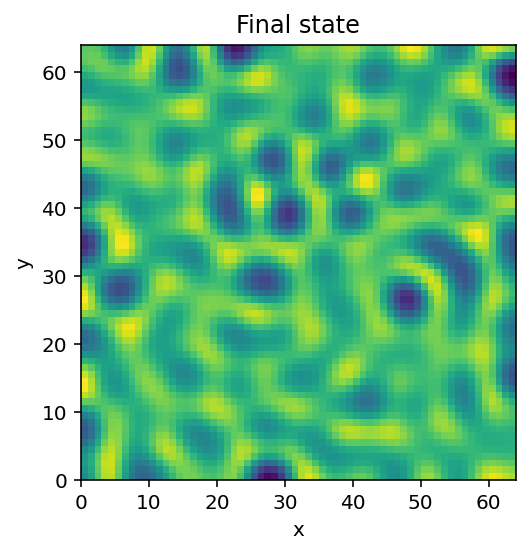

In [22]:
class KuramotoSivashinskyPDE(pde.PDEBase):
    """ Implementation of the normalized Kuramoto–Sivashinsky equation """

    def evolution_rate(self, state, t=0):
        """ implement the python version of the evolution equation """
        state_lap = state.laplace(bc='natural')
        state_lap2 = state_lap.laplace(bc='natural')
        state_grad = state.gradient(bc='natural')
        return -state_grad.to_scalar('squared_sum') / 2 - state_lap - state_lap2


grid = pde.UnitGrid([64, 64])
state = pde.ScalarField.random_uniform(grid)

eq = KuramotoSivashinskyPDE()
result = eq.solve(state, t_range=10, dt=0.01)
result.plot(title='Final state');

## Advanced interface for solving PDEs

In [23]:
from pprint import pprint

In [24]:
# initialize the grid, an initial condition, and the PDE
grid = pde.UnitGrid([32, 32])
field = pde.ScalarField.random_uniform(grid, -1, 1)
eq = pde.DiffusionPDE()

In [25]:
# try the explicit solver
solver1 = pde.ExplicitSolver(eq)
controller1 = pde.Controller(solver1, t_range=1, tracker=None)
sol1 = controller1.run(field, dt=1e-3)
sol1.label = 'py-pde'
pprint(controller1.diagnostics)

{'controller': {'package_version': '0.6.1',
                'profiler': {'solver': 0.32265499999999747,
                             'tracker': 2.7000000002885827e-05},
                'solver_class': 'ExplicitSolver',
                'solver_duration': '0:00:00.322747',
                'solver_start': '2020-04-15 14:25:50.202092',
                'stop_reason': 'Reached final time',
                'successful': True,
                't_end': 1.0,
                't_final': 1.0,
                't_start': 0},
 'solver': {'backend': 'numba',
            'class': 'ExplicitSolver',
            'dt': 0.001,
            'pde_class': 'DiffusionPDE',
            'scheme': 'euler',
            'steps': 1000,
            'stochastic': False}}


In [26]:
# try the standard scipy solver
solver2 = pde.ScipySolver(eq)
controller2 = pde.Controller(solver2, t_range=1, tracker=None)
sol2 = controller2.run(field)
sol2.label = 'scipy'
pprint(controller2.diagnostics)

{'controller': {'package_version': '0.6.1',
                'profiler': {'solver': 0.001535000000004061,
                             'tracker': 2.2999999998774e-05},
                'solver_class': 'ScipySolver',
                'solver_duration': '0:00:00.001573',
                'solver_start': '2020-04-15 14:25:50.694840',
                'stop_reason': 'Reached final time',
                'successful': True,
                't_end': 1.0,
                't_final': 1.0,
                't_start': 0},
 'solver': {'backend': 'numba',
            'class': 'ScipySolver',
            'dt': None,
            'pde_class': 'DiffusionPDE',
            'steps': 50,
            'stochastic': False}}


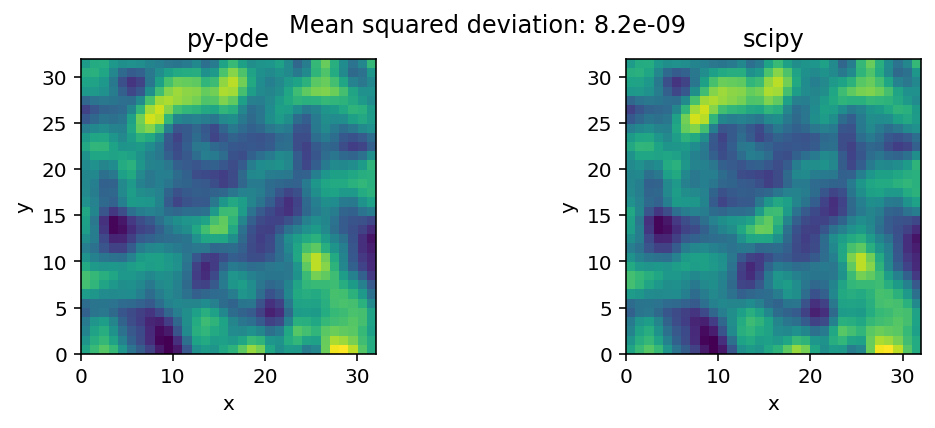

In [27]:
# plot both fields and give the deviation as the title
title = f'Mean squared deviation: {((sol1 - sol2)**2).average:.2g}'
pde.FieldCollection([sol1, sol2]).plot(title=title, show=True)